# Figures

## Plot of experimental, transfer learning model ensemble prediction (mean & variance) and ideal responses

1/1 [==============================] - 2s 2s/step
[0.68739223 0.3952623  0.20097305 0.70537573]
1/1 [==============================] - 1s 886ms/step
[0.68836933 0.3944399  0.20315787 0.7074283 ]
1/1 [==============================] - 1s 890ms/step
[0.6896168  0.38886994 0.20050246 0.7087305 ]
1/1 [==============================] - 1s 897ms/step
[0.6929542  0.39202765 0.20492443 0.71105003]
1/1 [==============================] - 1s 894ms/step
[0.68944675 0.39286235 0.20327479 0.7075437 ]
1/1 [==============================] - 1s 901ms/step
[0.6904711  0.3934161  0.20181823 0.7086201 ]
1/1 [==============================] - 1s 919ms/step
[0.6917025  0.38750595 0.20176885 0.7099054 ]
1/1 [==============================] - 1s 925ms/step
[0.69083863 0.39176494 0.20026866 0.71001524]
1/1 [==============================] - 1s 911ms/step
[0.69074374 0.39505914 0.20481099 0.7092842 ]
[[0.3298192  0.40696156 0.4815795  0.5462638  0.59329635 0.6220234
  0.63603604 0.6486849  0.6586055  0.6675548 

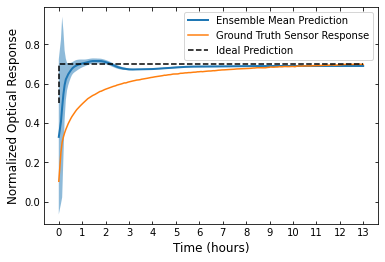

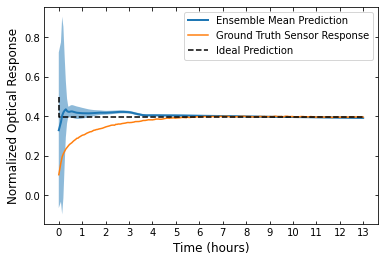

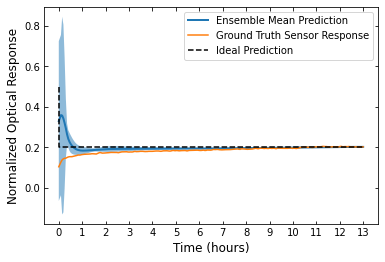

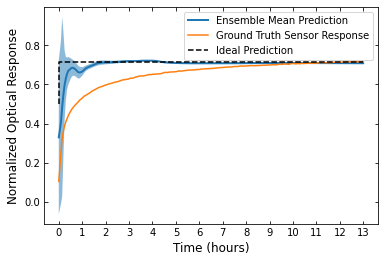

In [5]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

# 
NumEnsemble = 10
SequenceLength = 250
batch_size = 32
experiment_num = [11,46,57,70]#16,42
StdevsFromMean = 2 #1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively 
test_split = 0.2

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

df = pd.read_csv(r"../TrainingData/SimulatedTrainingSet10000.csv",sep=',',header=0)
df_simulated = df.iloc[:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_simulated.min().min(), df_simulated.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

# slicing 
X_test = df_norm_test.iloc[:,:SequenceLength].values
y_test = df_norm_test.iloc[:,SequenceLength-1].values
X_test = np.expand_dims(X_test, 2)
y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
y_test = np.expand_dims(y_test, 2)


Mean = tf.zeros([1,SequenceLength])
Variance = tf.zeros([1,SequenceLength])
X_predict = np.expand_dims(X_test[experiment_num,::], 2)

# idealTime = np.append([0,0], time.iloc[2:,].values)
# idealPrediction = np.ones(len(idealTime))*X_predict[0,-1,0]
# idealPrediction[0] = 0.5

NumGoodModels = 0

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X_test, y_test, batch_size=batch_size,verbose=0)
    if(loss<-2):
        prediction = bestModel.predict(X_predict)
        print(prediction[:,-1,0])
        Mean += prediction[:,:,0]
        Variance += (prediction[:,:,0])**2 + prediction[:,:,1]**2
        NumGoodModels += 1
Mean /= NumGoodModels
Variance /= NumGoodModels
Variance -= Mean**2

Mean = np.squeeze(Mean)
Stdev = np.squeeze(Variance**0.5)
idealTime = np.append([0,0], time.iloc[2:,].values)
time = np.array(time, dtype=float)

print(Mean)

for mean,x,stdev,num in zip(Mean,X_predict,Stdev,experiment_num):
    
    idealPrediction = np.ones(len(idealTime))*x[-1,0,0]
    idealPrediction[0] = 0.5

    fig, ax = plt.subplots()

    ax.fill_between(time, (mean+stdev*StdevsFromMean), (mean-stdev*StdevsFromMean), alpha=.5, linewidth=0)
    ax.plot(time, mean, linewidth=2, label='Ensemble Mean Prediction')
    plt.plot(time,tf.squeeze(x), label="Ground Truth Sensor Response")
    plt.plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle='--')
    
    ax.set_ylabel('Normalized Optical Response', fontsize = 12)
    ax.set_xlabel('Time (hours)', fontsize = 12)
    
    ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
    ax.tick_params(direction="in")
    ax.set_xticks(range(14))
    ax.legend()#loc='upper right')
    plt.savefig(f"../Figures/TransferLearningEnsemblePredictionIdealResponses{num}.tif", dpi=200, bbox_inches='tight')
    plt.show()

## Histogram of experimental and transfer learning model predicted t90 times

2023-10-31 00:04:42.702380: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


3/3 [==============================] - 2s 51ms/step - loss: -3.0722


2023-10-31 00:04:43.280724: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 1s 38ms/step

prediction t90 summary statistics
               0
count  78.000000
mean    4.741738
std     5.619471
min     0.051990
25%     0.103980
50%     1.013802
75%    12.997456
max    12.997456

experimental t90 summary statistics
               0
count  78.000000
mean    3.870576
std     2.569388
min     0.363929
25%     2.352539
50%     3.535308
75%     4.497120
max    12.945466

ratio of experimental to predicted t90 summary statistics
               0
count  78.000000
mean   17.246246
std    24.466857
min     0.047297
25%     0.377780
50%     3.199074
75%    24.000000
max    80.000000


/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


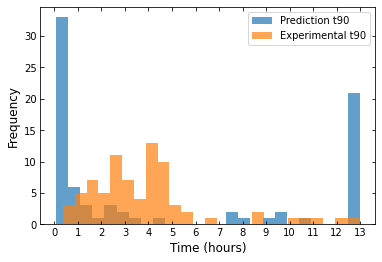

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

## input parameters

# number of models in the ensemble
NumEnsemble = 10

# length of time series
SequenceLength = 250
batch_size = 32
TestOrTrainDataset = 'test' #'train' or 'test'
test_split = 0.2

# t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely
t90Window = 0.1

NumberOfBins = 25

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

df = pd.read_csv(r"../TrainingData/SimulatedTrainingSet10000.csv",sep=',',header=0)
df_simulated = df.iloc[:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_simulated.min().min(), df_simulated.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test
    
Mean = tf.zeros([len(X),SequenceLength])
Variance = tf.zeros([len(X),SequenceLength])
Prediction = tf.zeros([len(X),SequenceLength])

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y, batch_size=batch_size)    
    
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
    Prediction = bestModel.predict(X)
    
    ## make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])
    
    Mean += Prediction[:,:,0]
    Variance += (Prediction[:,:,0])**2 + Prediction[:,:,1]**2
    
Mean /= NumEnsemble
Variance /= NumEnsemble
Variance -= Mean**2

PredictionT90 = []
ExperimentalT90 = []
MeanNormVariance = []

for mean,x,variance in zip(Mean,X,Variance):
    
    # Boolean 1D array of when the model prediction or experimental response was within 10% of
    # the final equilibrium experimental response
    PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
    ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))
    NormVariance = variance
    
    # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
    PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
    ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
    MeanNormVariance.append(np.mean(NormVariance))
    
PredictionT90 = [t90 * time.iloc[-1]/250 for t90 in PredictionT90]
ExperimentalT90 = [t90 * time.iloc[-1]/250 for t90 in ExperimentalT90]
MeanNormVariance = np.array(MeanNormVariance)

print('\nprediction t90 summary statistics')
print(pd.DataFrame(PredictionT90).describe())
print('\nexperimental t90 summary statistics')
print(pd.DataFrame(ExperimentalT90).describe())
print('\nratio of experimental to predicted t90 summary statistics')
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90)).describe())

freq, bins = np.histogram(PredictionT90, NumberOfBins)

BinNormVarianceMean = []
BinNormVarianceStdev = []
for i in range(NumberOfBins):
    indices = np.where((PredictionT90 >= bins[i]) & (PredictionT90 < bins[i+1]))
    BinNormVarianceMean.append(np.mean(MeanNormVariance[indices]))
    BinNormVarianceStdev.append(np.std(MeanNormVariance[indices]))

fig, ax = plt.subplots()
ax.hist(PredictionT90, histtype="stepfilled", bins=NumberOfBins, alpha=0.7,label='Prediction t90')
ax.hist(ExperimentalT90, histtype="stepfilled", bins=NumberOfBins, alpha=0.7,label='Experimental t90')

ax.set_ylabel('Frequency', fontsize = 12)
ax.set_xlabel('Time (hours)', fontsize = 12)

ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
ax.set_xticks(range(14))
ax.legend(loc='upper right')

plt.savefig(".."+"/Figures/PredictedTransferLearningt90Histogram.tif", dpi=200, bbox_inches='tight')
plt.show()

## Histogram of experimental and predicted t90 times with variance subplot indicating S/N

3/3 [==============================] - 1s 53ms/step

prediction t90 summary statistics
               0
count  78.000000
mean    2.849442
std     4.124710
min     0.051990
25%     0.311939
50%     0.779847
75%     2.638483
max    12.997456

experimental t90 summary statistics
               0
count  78.000000
mean    3.870576
std     2.569388
min     0.363929
25%     2.352539
50%     3.535308
75%     4.497120
max    12.945466

ratio of experimental to predicted t90 summary statistics
               0
count  78.000000
mean    7.247214
std     9.955742
min     0.080000
25%     1.019222
50%     3.033333
75%    10.271429
max    61.000000
[ 0.05198982  0.56980845  1.08762708  1.60544571  2.12326434  2.64108297
  3.1589016   3.67672023  4.19453886  4.71235749  5.23017612  5.74799474
  6.26581337  6.783632    7.30145063  7.81926926  8.33708789  8.85490652
  9.37272515  9.89054378 10.40836241 10.92618104 11.44399967 11.9618183
 12.47963693 12.99745556]


/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


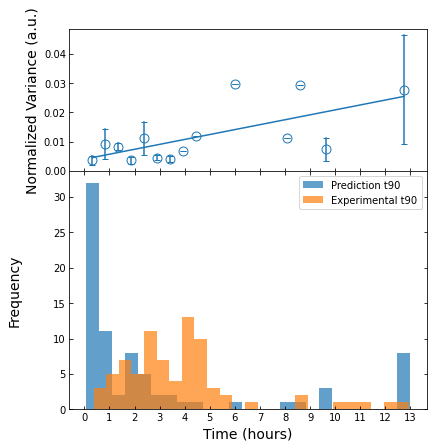

In [10]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
import pylab
from sklearn.linear_model import LinearRegression

## input parameters

# number of models in the ensemble
NumEnsemble = 10
# length of time series
SequenceLength = 250
batch_size = 32
TestOrTrainDataset = 'test' #'train' or 'test'
t90Window = 0.1 # t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely
test_split = 0.2
NumberOfBins = 25
viridisColour1 = 30
viridisColour2 = 120
markerSize = 80

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

df = pd.read_csv(r"../TrainingData/SimulatedTrainingSet10000.csv",sep=',',header=0)
df_simulated = df.iloc[:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_simulated.min().min(), df_simulated.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test
    
Mean = tf.zeros([len(X),SequenceLength])
Variance = tf.zeros([len(X),SequenceLength])
Prediction = tf.zeros([len(X),SequenceLength])

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y, batch_size=batch_size)    
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
    Prediction = bestModel.predict(X)
    

    # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])
    
    Mean += Prediction[:,:,0]
    Variance += (Prediction[:,:,0])**2 + Prediction[:,:,1]**2
    
Mean /= NumEnsemble
Variance /= NumEnsemble
Variance -= Mean**2

PredictionT90 = []
ExperimentalT90 = []
MeanNormVariance = []

for mean,x,variance in zip(Mean,X,Variance):
    
    # Boolean 1D array of when the model prediction or experimental response was within 10% of
    # the final equilibrium experimental response
    PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
    ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))
    NormVariance = variance/x[-1]
    
    # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
    PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
    ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
    MeanNormVariance.append(np.mean(NormVariance))
    
PredictionT90 = [t90 * time.iloc[-1]/250 for t90 in PredictionT90]
ExperimentalT90 = [t90 * time.iloc[-1]/250 for t90 in ExperimentalT90]
MeanNormVariance = np.array(MeanNormVariance)

print('\nprediction t90 summary statistics')
print(pd.DataFrame(PredictionT90).describe())
print('\nexperimental t90 summary statistics')
print(pd.DataFrame(ExperimentalT90).describe())
print('\nratio of experimental to predicted t90 summary statistics')
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90)).describe())

freq, bins = np.histogram(PredictionT90, NumberOfBins)
print(bins)
BinNormVarianceMean = []
BinNormVarianceStdev = []
for i in range(NumberOfBins):
    indices = np.where((PredictionT90 >= bins[i]) & (PredictionT90 <= bins[i+1]))
    BinNormVarianceMean.append(np.mean(MeanNormVariance[indices]))
    BinNormVarianceStdev.append(np.std(MeanNormVariance[indices]))

BinCenters = np.array([(bins[i+1]+bins[i])/2 for i in range(NumberOfBins)])
BinNormVarianceMean = np.array(BinNormVarianceMean)
BinNormVarianceStdev = np.array(BinNormVarianceStdev)

LinearFit = LinearRegression()
BinCentersDropNa = BinCenters[~np.isnan(BinNormVarianceMean)]
BinNormVarianceMeanDropNa = BinNormVarianceMean[~np.isnan(BinNormVarianceMean)]
BinNormVarianceStdevDropNa = BinNormVarianceStdev[~np.isnan(BinNormVarianceMean)]
LinearFit.fit(np.reshape(BinCentersDropNa,(-1, 1)), np.reshape(BinNormVarianceMeanDropNa,(-1, 1)))

fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [1.8, 3]},figsize=[6.4, 7])

ax1.scatter(BinCentersDropNa,BinNormVarianceMeanDropNa, facecolor=(0,0,0,0), marker='o', s=markerSize, edgecolor='tab:blue')#pylab.cm.viridis(viridisColour1))
ax1.plot([BinCentersDropNa, BinCentersDropNa], [BinNormVarianceMeanDropNa+BinNormVarianceStdevDropNa, BinNormVarianceMeanDropNa-BinNormVarianceStdevDropNa], marker="_", color='tab:blue')#pylab.cm.viridis(viridisColour1))
ax1.plot(BinCentersDropNa,LinearFit.predict(np.reshape(BinCentersDropNa,(-1, 1))),color='tab:blue')#pylab.cm.viridis(viridisColour1))
ax1.set_ylabel('Normalized Variance (a.u.)', fontsize = 14)
ax1.tick_params(direction="in")

ax2.hist(PredictionT90, histtype="stepfilled", bins=NumberOfBins, alpha=0.7,label='Prediction t90',color='tab:blue')#pylab.cm.viridis(viridisColour1))
ax2.hist(ExperimentalT90, histtype="stepfilled", bins=NumberOfBins, alpha=0.7,label='Experimental t90',color='tab:orange')#pylab.cm.viridis(viridisColour2))

ax2.set_ylabel('Frequency', fontsize = 14, labelpad=32)
ax2.set_xlabel('Time (hours)', fontsize = 14)

ax2.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax2.tick_params(direction="in")
ax2.set_xticks(range(14))
ax2.legend(loc='upper right')

fig.subplots_adjust(hspace=0)

plt.savefig(".."+"/Figures/PredictedTransferLearningt90HistogramNormVariance.tif", dpi=200, bbox_inches='tight')
plt.show()

## Box and whisker plot of ratio of experimental to predicted t90 times

3/3 [==============================] - 1s 55ms/step
               0
count  78.000000
mean    7.247214
std     9.955742
min     0.080000
25%     1.019222
50%     3.033333
75%    10.271429
max    61.000000


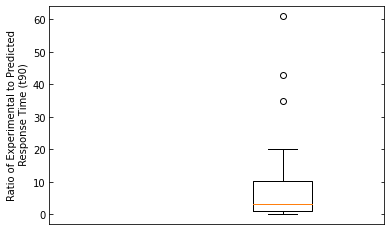

In [11]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

## input parameters

# number of models in the ensemble
NumEnsemble = 10
# length of time series
SequenceLength = 250
batch_size = 32
TestOrTrainDataset = 'test' #'train' or 'test'
t90Window = 0.1 # t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely
test_split = 0.2

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

df = pd.read_csv(r"../TrainingData/SimulatedTrainingSet10000.csv",sep=',',header=0)
df_simulated = df.iloc[:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_simulated.min().min(), df_simulated.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test
    
Mean = tf.zeros([len(X),SequenceLength])
Prediction = tf.zeros([len(X),SequenceLength])

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y, batch_size=batch_size)    
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
    Prediction = bestModel.predict(X)
    

    # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])
    
    Mean += Prediction[:,:,0]
        
Mean /= NumEnsemble

PredictionT90 = []
ExperimentalT90 = []

for mean,x in zip(Mean,X):
    
    # Boolean 1D array of when the model prediction or experimental response was within 10% of
    # the final equilibrium experimental response
    PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
    ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))

    # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
    PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
    ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
    
PredictionT90 = [t90 * time.iloc[-1]/250 for t90 in PredictionT90]
ExperimentalT90 = [t90 * time.iloc[-1]/250 for t90 in ExperimentalT90]

RatioT90 = np.array(ExperimentalT90)/np.array(PredictionT90)

print(pd.DataFrame(RatioT90).describe())

fig, ax = plt.subplots()
ax.boxplot(RatioT90)#,showmeans=False,showextrema=False,showmedians=True,quantiles=[0.25,0.75])

# plt.xlabel("")
plt.ylabel("Ratio of Experimental to Predicted\n Response Time (t90)")
# plt.text(0.55,25,"Mean "+str(RatioT90.mean())+"\nLower Quartile "+str(np.quantile(RatioT90,0.25))+"\nMedian "+str(np.quantile(RatioT90,0.5))+"\nUpper Quartile "+str(np.quantile(RatioT90,0.75)))
ax.tick_params(right=True, top=False, bottom=False, labelbottom=False, labelright=False, labeltop=False)
ax.tick_params(direction="in")
ax.set_xlim([0.4,1.26])

plt.savefig("../Figures/BoxandWhiskerPlotTransferLearningPredictedt90Ratio.tif", dpi=200, bbox_inches='tight')
plt.show()

# Useful plots, but not figures

## Individual plots of all experimental, ensemble prediction (mean & variance) and ideal responses

2023-10-03 09:58:17.894734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-03 09:58:17.898096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-03 09:58:17.898224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-03 09:58:17.898545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

3/3 [==============================] - 1s 31ms/step - loss: -3.4998


2023-10-03 09:58:21.355758: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 0s 31ms/step


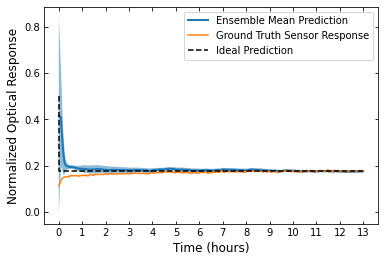

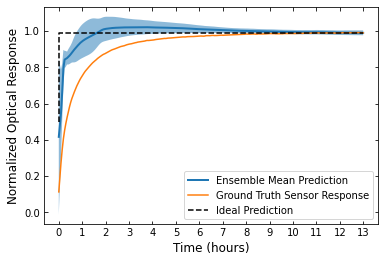

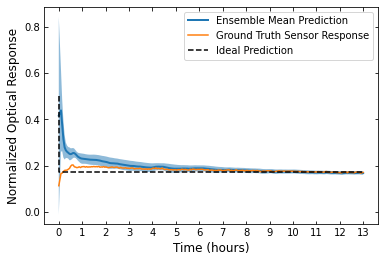

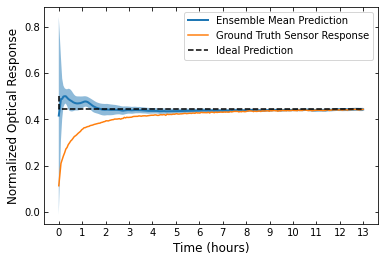

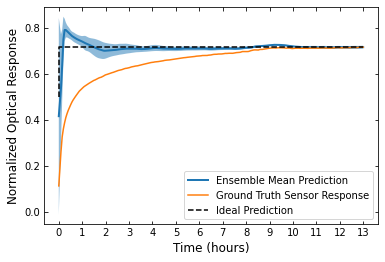

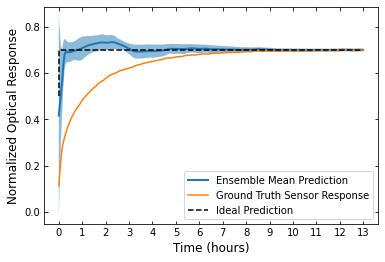

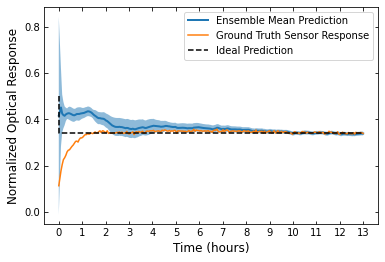

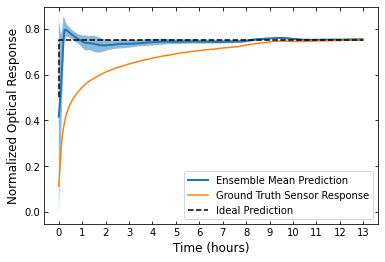

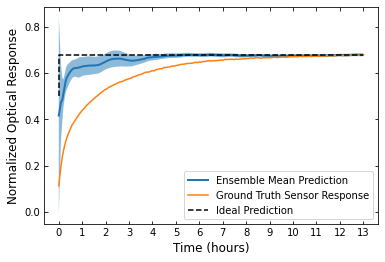

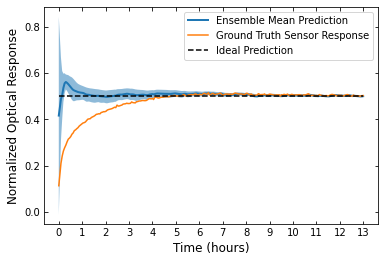

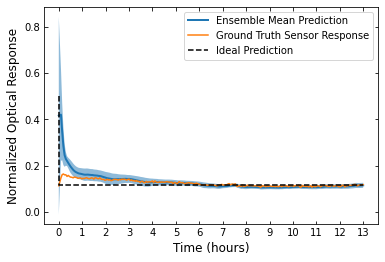

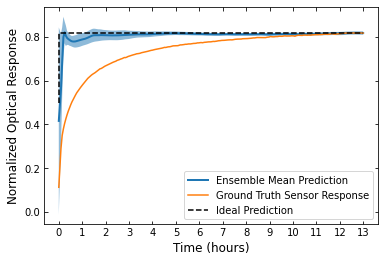

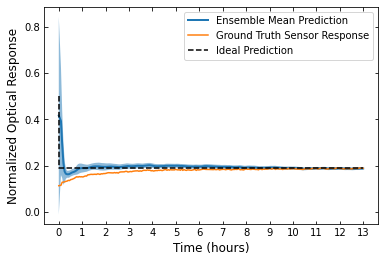

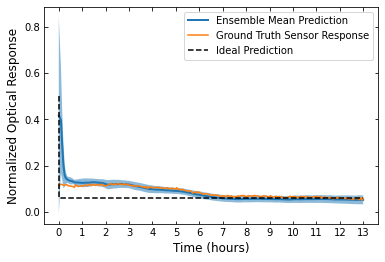

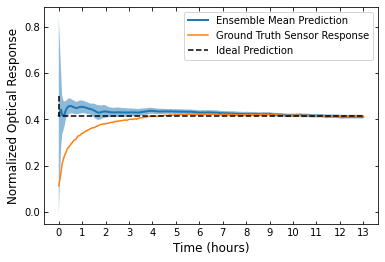

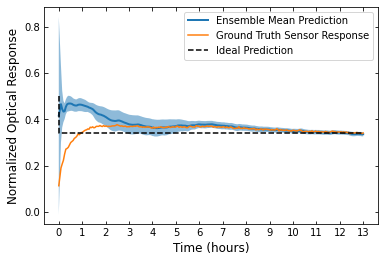

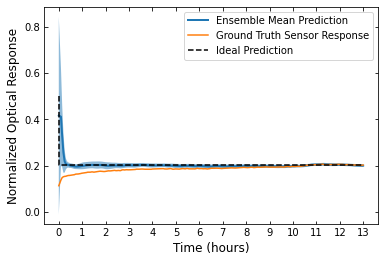

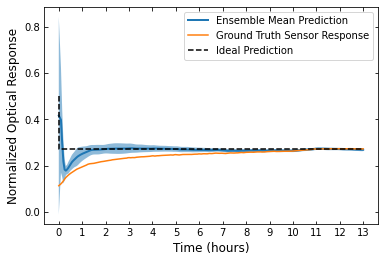

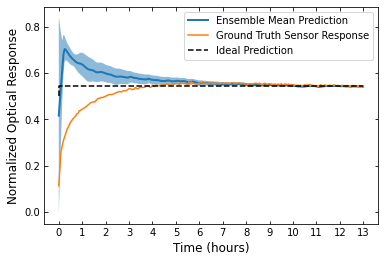

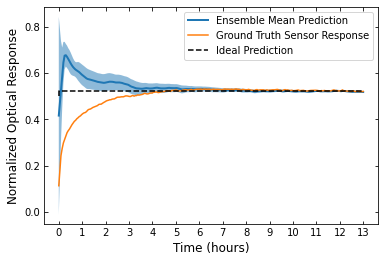

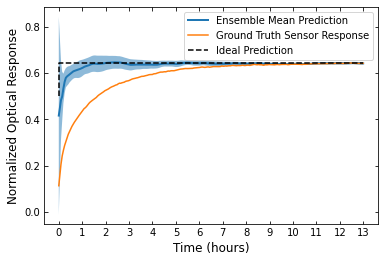

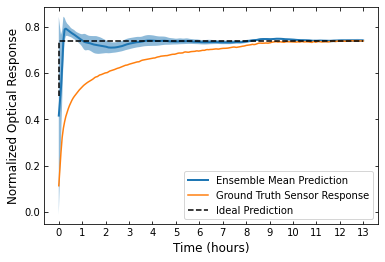

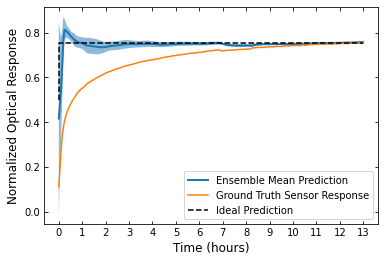

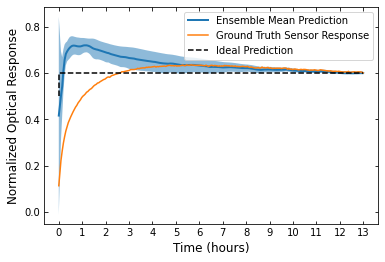

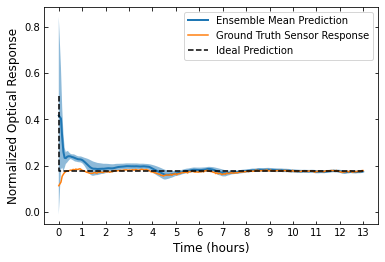

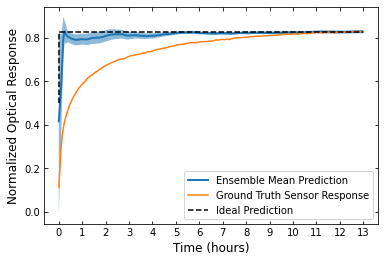

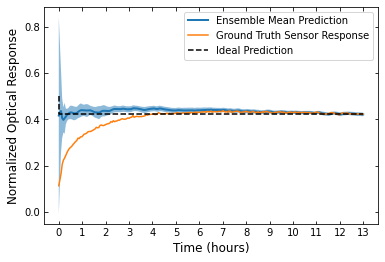

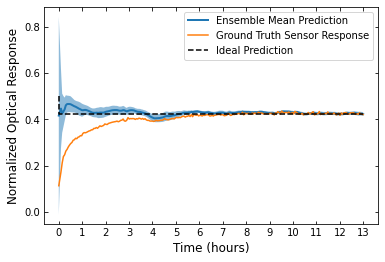

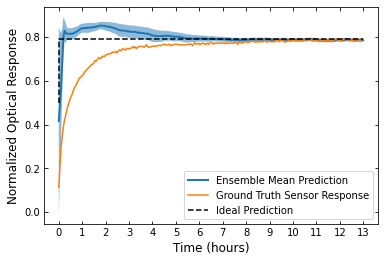

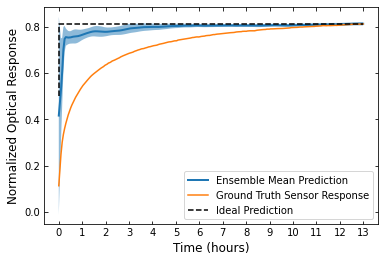

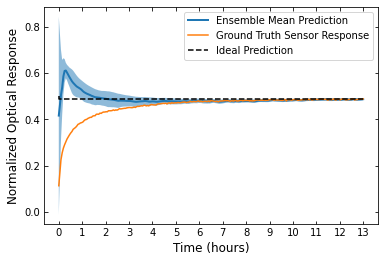

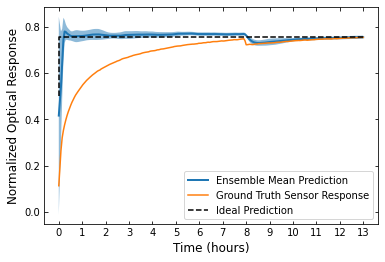

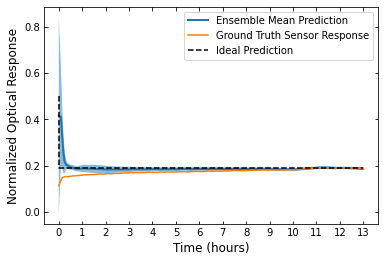

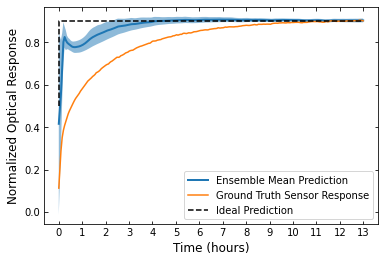

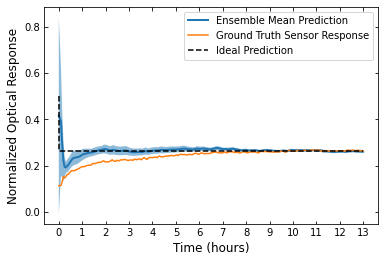

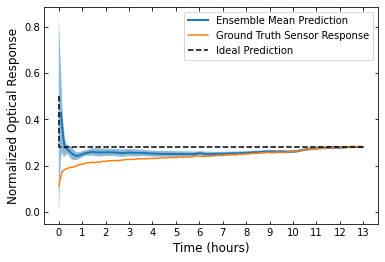

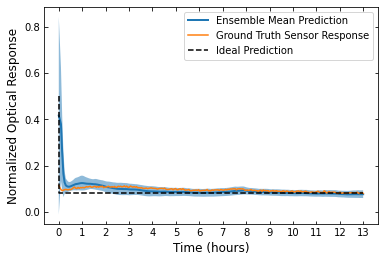

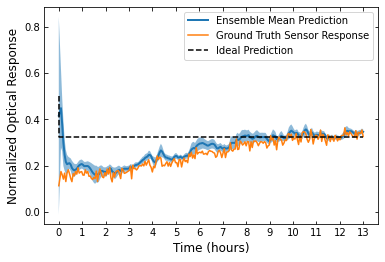

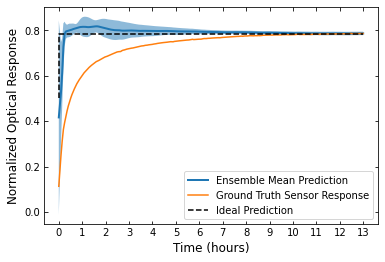

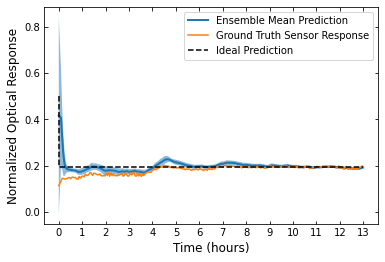

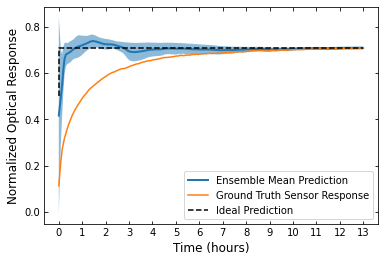

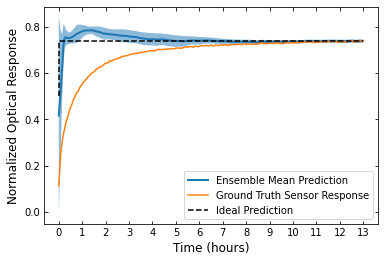

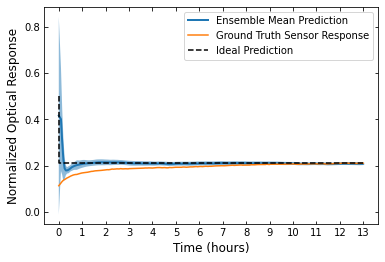

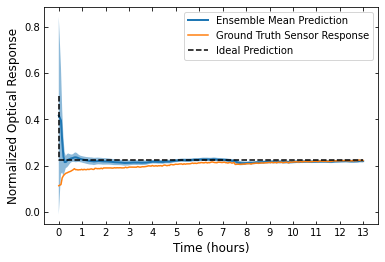

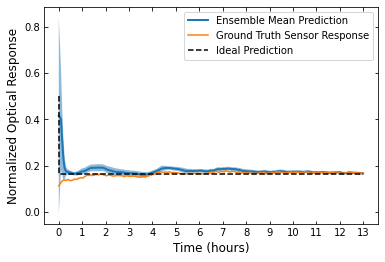

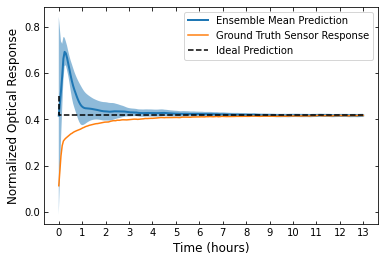

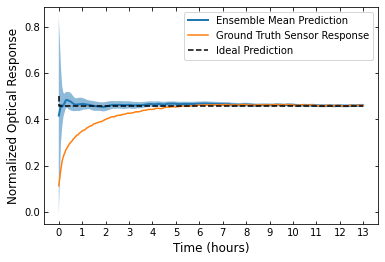

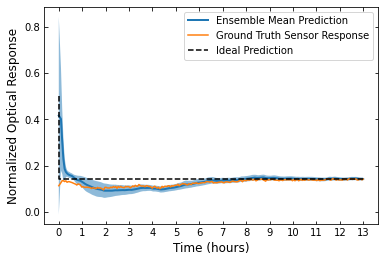

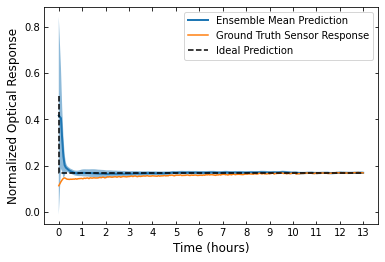

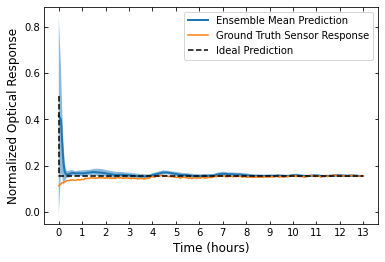

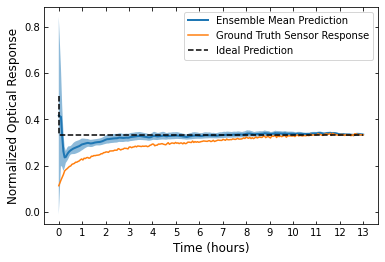

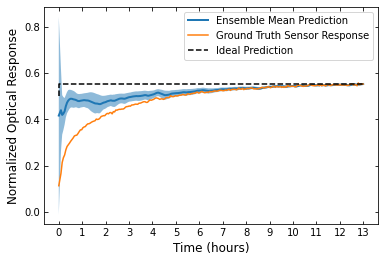

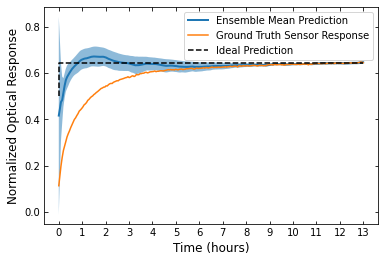

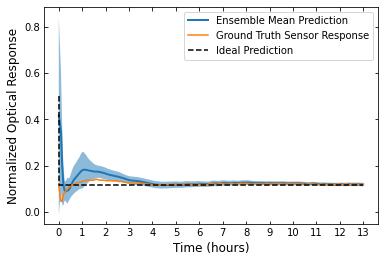

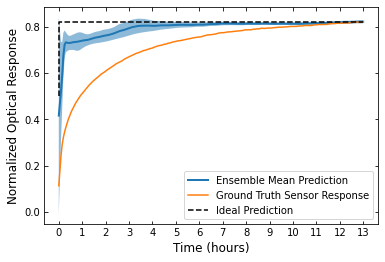

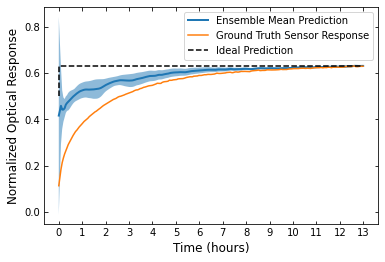

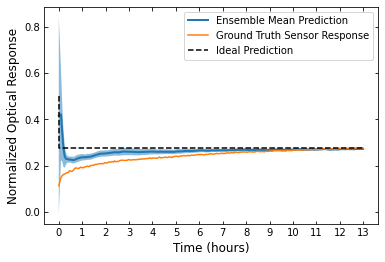

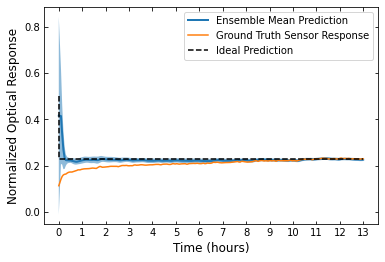

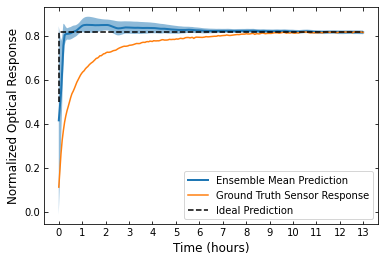

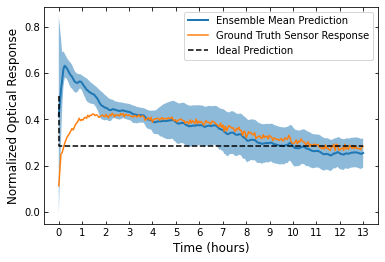

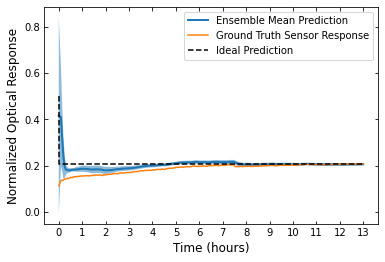

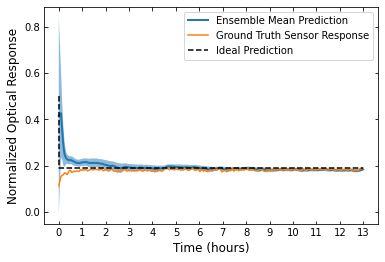

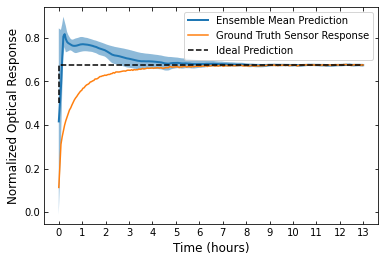

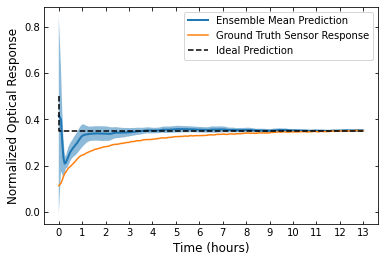

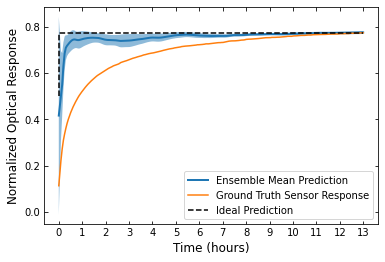

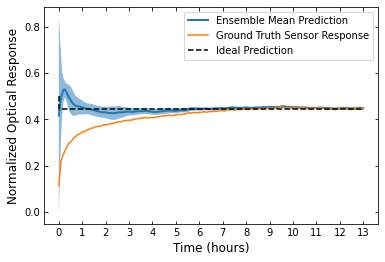

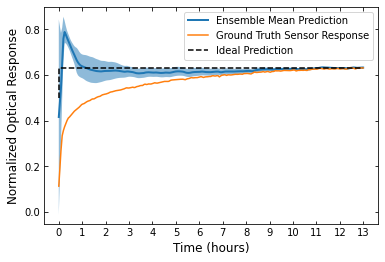

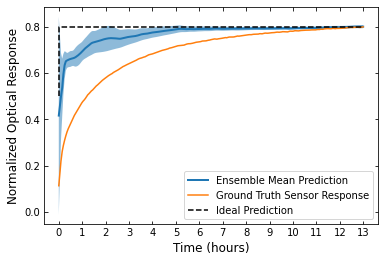

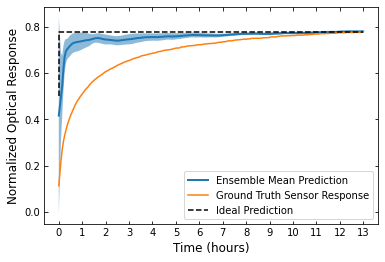

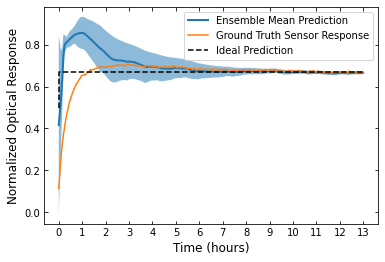

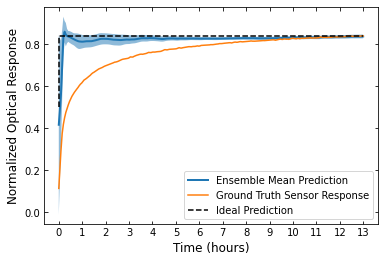

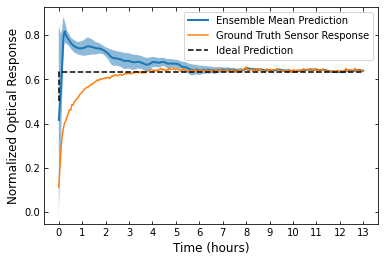

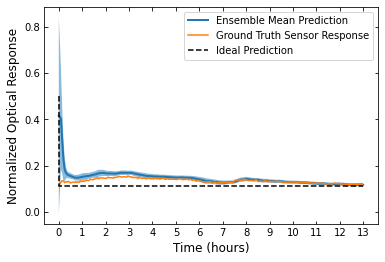

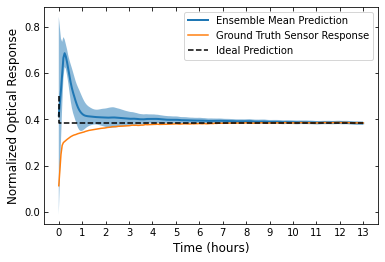

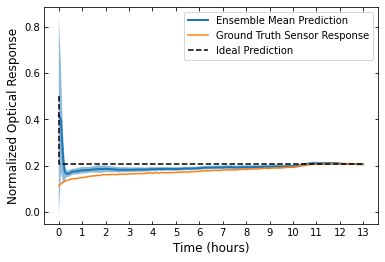

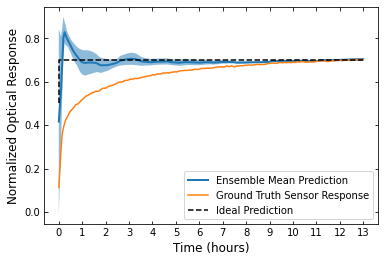

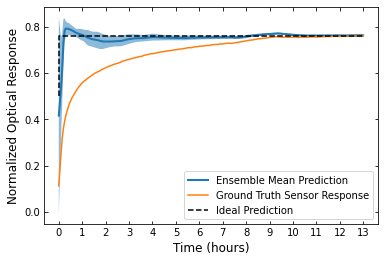

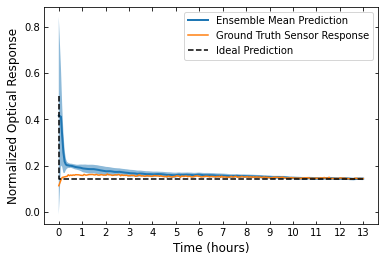

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

## input parameters

# number of models in the ensemble
NumEnsemble = 10
# length of time series
SequenceLength = 250
batch_size = 32
StdevsFromMean = 2 #1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively 
TestOrTrainDataset = 'test' #'train' or 'test'
test_split = 0.2

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

df = pd.read_csv(r"../TrainingData/SimulatedTrainingSet10000.csv",sep=',',header=0)
df_simulated = df.iloc[:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_simulated.min().min(), df_simulated.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test
    
Mean = tf.zeros([len(X),SequenceLength])
Variance = tf.zeros([len(X),SequenceLength])

NumGoodModels = 0

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y, batch_size=batch_size)
    if(loss<-2):
        # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
        # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
        #for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
        prediction = bestModel.predict(X)
        
        Mean += prediction[:,:,0]
        Variance += (prediction[:,:,0])**2 + prediction[:,:,1]**2
        NumGoodModels += 1
        
Mean /= NumGoodModels
Variance /= NumGoodModels
Variance -= Mean**2

for mean,variance,x_train in zip(Mean,Variance,X):
    
    Stdev = np.squeeze(variance**0.5)
    
    time = np.array(time, dtype=float)
    idealPrediction = np.ones(len(idealTime))*x_train[-1]
    idealPrediction[0] = 0.5
    
    fig, ax = plt.subplots()

    ax.fill_between(time, (mean+Stdev*StdevsFromMean), (mean-Stdev*StdevsFromMean), alpha=.5, linewidth=0)
    ax.plot(time, mean, linewidth=2, label='Ensemble Mean Prediction')
    plt.plot(time,tf.squeeze(x_train), label="Ground Truth Sensor Response")
    plt.plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle='--')

    ax.set_ylabel('Normalized Optical Response', fontsize = 12)
    ax.set_xlabel('Time (hours)', fontsize = 12)

    ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
    ax.tick_params(direction="in")
    ax.set_xticks(range(14))
    ax.legend()

    plt.show()

## Plot of experimental, individual ensemble predictions (including mean) and ideal responses

1/1 [==============================] - 0s 383ms/step
[0.69721854]
1/1 [==============================] - 0s 390ms/step
[0.70159304]
1/1 [==============================] - 0s 393ms/step
[0.69757104]
1/1 [==============================] - 0s 376ms/step
[0.7035707]
1/1 [==============================] - 1s 972ms/step
[0.6975473]
1/1 [==============================] - 0s 378ms/step
[0.69926065]
1/1 [==============================] - 0s 384ms/step
[0.7074984]
1/1 [==============================] - 0s 386ms/step
[0.6979861]
1/1 [==============================] - 0s 377ms/step
[0.69987726]
1/1 [==============================] - 0s 386ms/step
[0.6953896]


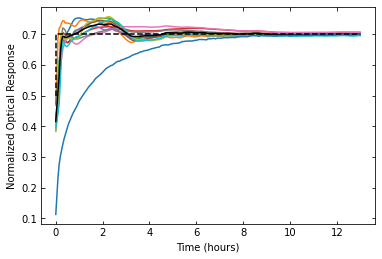

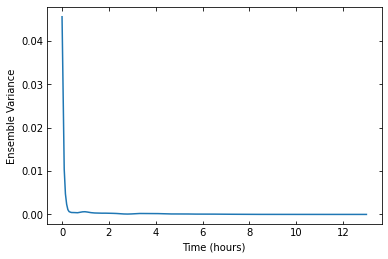

In [5]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split


NumEnsemble = 10
SequenceLength = 250
batch_size = 32
predict_num = 5
TestOrTrainDataset = 'test' #'train' or 'test'
test_split = 0.2

df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
labels = df_full.iloc[1:,0]
df_train = df_full.iloc[1:,1:]

df = pd.read_csv(r"../TrainingData/SimulatedTrainingSet10000.csv",sep=',',header=0)
df_simulated = df.iloc[:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_simulated.min().min(), df_simulated.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test

Mean = tf.zeros([1,SequenceLength])
Variance = tf.zeros([1,SequenceLength])
X_predict = np.expand_dims(X[predict_num,::], 0)

idealTime = np.append([0,0], time.iloc[2:,].values)
idealPrediction = np.ones(len(idealTime))*X_predict[0,-1,0]
idealPrediction[0] = 0.5

fig, ax = plt.subplots()
NumGoodModels = 0
for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataTransferLearningEnsembleModels/ExperimentalDataTransferLearningEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y, batch_size=batch_size)
    if(loss<-2):
        prediction = bestModel.predict(X_predict)
        plt.plot(time,tf.squeeze(prediction[:,:,0]),label=f"model {NumGoodModels} Prediction")
        print(prediction[:,-1,0])
        Mean += prediction[:,:,0]
        Variance += (prediction[:,:,0])**2 + prediction[:,:,1]**2
        NumGoodModels += 1
Mean /= NumGoodModels
Variance /= NumGoodModels
Variance -= Mean**2

plt.plot(time,tf.squeeze(Mean),label="Mean Prediction",color='k')
plt.plot(time,tf.squeeze(X_predict), label="Ground Truth Sensor Response")
plt.plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle='--')
plt.xlabel("Time (hours)")
plt.ylabel("Normalized Optical Response")

ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
# plt.legend(loc='right')
plt.show()

fig, ax = plt.subplots()
plt.plot(time,tf.squeeze(Variance), label="Variance")
plt.xlabel("Time (hours)")
plt.ylabel("Ensemble Variance")
ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
plt.show()